# Treinamento regressão

In [1]:
treinar = {
    'GP': False,
    'RegressaoLinear': True,
    'BayesianLinearRegression': True,
    'BayesianPolinomialLinearRegression': True,
    'BayesianLinearRegressionNew': True,
    'BayesianPolinomialLinearRegressionNew': True,
    'BayesianRBFLinearRegression': True,
}

In [2]:
# Métrica da otimização bayesiana
# Selecione: rmse, nlpd
metrica = 'rmse'
#metrica = 'nlpd'

In [3]:
bo_max_iter=50

## Conjunto de dados

In [4]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv', index_col=0)

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Valor  |
| ---------------- | --------------------------------------------------- | ------ |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | `int: 0 false - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | `int: 0 false - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | `int: 0 false - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | `int: 0 false - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | `int: 0 false - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | `float` |
| `rooms`          | Quantidade de quartos                               | `int` |
| `bathroom`       | Quantidade de banheiros                             | `int` |
| `floor`          | Andar localizado o imóvel                           | `int`. `0` pressuposto para casa |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | `int: 0 false - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | `int: 0 false - 1 true` |
| `furniture`      | Se a casa já vem mobiliada                          | `int: 0 false - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | `float` |

In [5]:
dataset.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
3489,0,0,0,1,0,69,2,2,1,14,0,1,0,2125
669,1,0,0,0,0,450,4,5,6,1,1,1,0,12000
6003,0,0,0,0,1,61,3,1,1,2,0,1,0,1800
5333,1,0,0,0,0,54,2,2,1,2,0,1,0,2327
1524,0,0,0,1,0,85,3,2,1,7,0,1,0,2415


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [6]:
from sklearn.model_selection import train_test_split

# FIXME: Separar respeitando a proproção em cada cidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train = X_train[:50]
#y_train = y_train[:50]

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (7481, 13)
Quantidade de elementos selecionados para teste: (3207, 13)


### Normalização - AJEITAR

A normalização aplicada no conjunto de dados foi a [min/max scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
\begin{aligned}
\mathcal{D}_{std} &= \frac{\mathcal{D} - \mathcal{D}.min(axis=0)}{\mathcal{D}.max(axis=0) - \mathcal{D}.min(axis=0)}; \\
\mathcal{D}_{scaled} &= \mathcal{D}_{std} \cdot (max - min) + min.
\end{aligned}
A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [7]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler

## Treinamento

Com o intuito de selecionar os melhores hiperparâmetros, para cada um dos modelo testados, foi realizado uma validação cruzada por meio de _5-folds_, onde ocorreu uma otimização bayesiana em cada um dos _folds_. Os hiperparâmetros foram selecionados de acordo com o resultado da métrica **DECIDIR**, descrita adiante neste trabalho.

Após a seleção dos hiperparâmetros, cada um dos modelos foram avaliados com conjunto de testes por meio das métricas descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}
\end{aligned}

In [8]:
from trabalho.util.metrica import rmse

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [9]:
from trabalho.util.metrica import nlpd

## Modelos utilizados

In [10]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])

### Processos Gaussianos

In [11]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [12]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    # Combinação de kernels
    #gpflow.kernels.Combination(),
    #gpflow.kernels.ChangePoints(),
    #gpflow.kernels.Product(),
    #gpflow.kernels.Sum(),
    
    # Imagem (convolução)
    #gpflow.kernels.Convolutional(),
    
    # Dados estacionários
    #gpflow.kernels.Stationary(),
    #gpflow.kernels.Periodic(), # Can be used to wrap any Stationary kernel to transform it into a periodic version
    #gpflow.kernels.AnisotropicStationary(), 
    #gpflow.kernels.IsotropicStationary(),
    
    # Multi objetivo
    #gpflow.kernels.MultioutputKernel(),
    #gpflow.kernels.IndependentLatent(),
    #gpflow.kernels.LinearCoregionalization(),
    #gpflow.kernels.SeparateIndependent(),
    #gpflow.kernels.SharedIndependent(),
    
    # Outros exóticos
    #gpflow.kernels.Coregion(),
    
    # Ok
    #gpflow.kernels.Kernel(), # Classe base
    #gpflow.kernels.Static(), # Classe base
    
    #gpflow.kernels.ArcCosine(),
    #gpflow.kernels.Constant(),
    #gpflow.kernels.Cosine(),
    #gpflow.kernels.Exponential(),
    #gpflow.kernels.Linear(),
    
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    #gpflow.kernels.Polynomial(),
    gpflow.kernels.SquaredExponential(), # RBF
    #gpflow.kernels.RationalQuadratic(),
    
    #gpflow.kernels.White(),
]


means = [
    # Padrão
    gpflow.mean_functions.Zero(),
    # Média
    gpflow.mean_functions.Linear(),
]

dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
    {
        'name': 'mean_function',
        'type': 'categorical',
        'domain': means
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel', 'type': 'categorical', 'domain': [0, 1, 2, 3]},
 {'name': 'mean_function', 'type': 'categorical', 'domain': [0, 1]}]

### Regressão Linear

#### Regressão Linear (não bayesiana)

In [13]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

##### Hiperparâmetros a serem procurados

In [14]:
dominio_regressao_linear = Dominio([])

#### Regressão Linear Bayesiana

In [15]:
from trabalho.modelos.bayesian_linear_regression import BayesianLinearRegression

BayesianLinearRegression

trabalho.modelos.bayesian_linear_regression.BayesianLinearRegression

In [16]:
from trabalho.modelos.bayesian_linear_regression_new import BayesianLinearRegressionNew

BayesianLinearRegressionNew

trabalho.modelos.bayesian_linear_regression_new.BayesianLinearRegressionNew

##### Hiperparâmetros a serem procurados

In [17]:
dominio_regressao_linear_bayesiana = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    }
])

In [18]:
dominio_regressao_linear_bayesiana_new = Dominio([
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 1)
    }
])

#### Regressão Linear Bayesiana Polinomial

In [19]:
from trabalho.modelos.bayesian_polinomial_linear_regression import BayesianPolinomialLinearRegression

BayesianPolinomialLinearRegression

trabalho.modelos.bayesian_polinomial_linear_regression.BayesianPolinomialLinearRegression

In [20]:
from trabalho.modelos.bayesian_polinomial_linear_regression_new import BayesianPolinomialLinearRegressionNew

BayesianPolinomialLinearRegressionNew

trabalho.modelos.bayesian_polinomial_linear_regression_new.BayesianPolinomialLinearRegressionNew

##### Hiperparâmetros a serem procurados

In [21]:
dominio_regressao_linear_bayesiana_polinomial = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

In [22]:
dominio_regressao_linear_bayesiana_polinomial_new = Dominio([
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

#### Regressão Linear Bayesiana com kernel RBF

In [23]:
from trabalho.modelos.bayesian_rbf_linear_regression import BayesianRBFLinearRegression

BayesianRBFLinearRegression

trabalho.modelos.bayesian_rbf_linear_regression.BayesianRBFLinearRegression

##### Hiperparâmetros a serem procurados

In [24]:
dominio_regressao_linear_bayesiana_rbf = Dominio([
#     {
#         'name': 'm0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
#     {
#         'name': 'S0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 1)
    },
    {
        'name': 'mean_rbf_arbitrario',
        'type': 'continuous',
        'domain': (-1, 1)
    },
    {
        'name': 'lambda_rbf_arbitrario',
        'type': 'continuous',
        'domain': (1e-7, 1)
    }
])

### Validação - Seleção de modelos

In [25]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm


def f(Modelo, X, y, metrica, k_folds, relatorio_geral, **kwargs):
    relatorio_parcial = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold', 'tentativa'])
    
    for fold, X_train, X_validation, y_train, y_validation in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        resultado = treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs)
        
        total_execucoes = len(relatorio_geral)
        tentativa = (total_execucoes - total_execucoes % k_folds) / k_folds
        
        relatorio_parcial.loc[len(relatorio_parcial)] = resultado + [fold, tentativa]
        relatorio_geral.loc[total_execucoes] = resultado + [fold, tentativa]


    medias = relatorio_parcial.mean()
    
    # Fixme: juntar com o relatório final
    #relatorio_parcial
    
    return medias[metrica]


def treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs):
    X_scaler = Scaler()
    y_scaler = Scaler()

    X_train_transform      = X_scaler.fit_transform(X_train)
    X_validation_transform = X_scaler.transform(X_validation)
    y_train_transform      = y_scaler.fit_transform(y_train)
    y_validation_transform = y_scaler.transform(y_validation)

    modelo = Modelo(**kwargs)
    modelo.fit(X_train_transform, y_train_transform)

    means, vars = modelo.predict(X_validation_transform)
    means = means.reshape((-1, 1))
    vars = vars.reshape((-1, 1))

    means_dimensao_correta = y_scaler.inverse_transform(means)
    std_errors_modelo = np.sqrt(vars)
    std_errors_scaler = np.sqrt(y_scaler.var_)
    
    vars_dimensao_correta = (std_errors_modelo * std_errors_scaler)**2

    erro_rmse = rmse(means_dimensao_correta, y_validation)
    erro_nlpd = nlpd(means_dimensao_correta, vars_dimensao_correta, y_validation)
    
    return [Modelo.__name__, kwargs, erro_rmse, erro_nlpd]


def otimizacao_bayesiana(Modelo, dominio, X, y, k_folds=5, metrica='rmse', max_iter=50):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold', 'tentativa'])
    funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, k_folds=5, metrica=metrica, relatorio_geral=relatorio)

    bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
    bo.run_optimization(max_iter=max_iter)

    try:
        bo.plot_convergence()
        bo.plot_acquisition()
    except Exception as e:
        print(e)

    print('RMSE:', bo.fx_opt)
    print('Parâmetros:', bo.x_opt)

    return relatorio

In [26]:
modelos = {
    'GP': (GP, dominio_gp),
    'RegressaoLinear': (RegressaoLinear, dominio_regressao_linear),
    'BayesianLinearRegression': (BayesianLinearRegression, dominio_regressao_linear_bayesiana),
    'BayesianPolinomialLinearRegression': (BayesianPolinomialLinearRegression, dominio_regressao_linear_bayesiana_polinomial),
    'BayesianLinearRegressionNew': (BayesianLinearRegressionNew, dominio_regressao_linear_bayesiana_new),
    'BayesianPolinomialLinearRegressionNew': (BayesianPolinomialLinearRegressionNew, dominio_regressao_linear_bayesiana_polinomial_new),
    'BayesianRBFLinearRegression': (BayesianRBFLinearRegression, dominio_regressao_linear_bayesiana_rbf),
}

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

GP False
RegressaoLinear True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 46.95it/s]


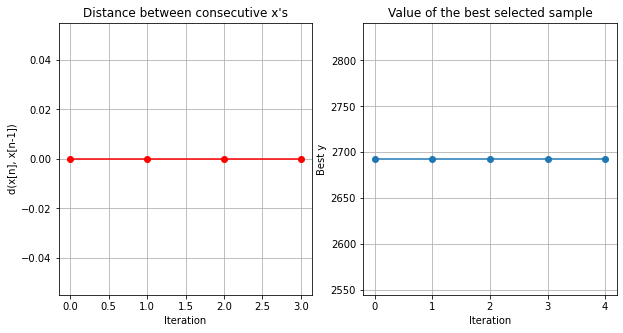

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

not enough values to unpack (expected 2, got 0)
RMSE: 2692.709121747069
Parâmetros: []
BayesianLinearRegression True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s]


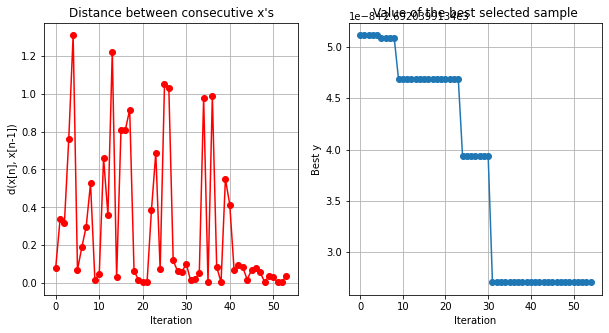

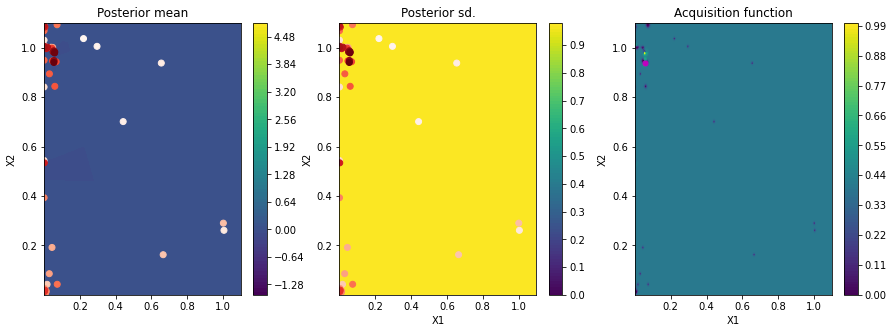

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

RMSE: 2692.039913427051
Parâmetros: [0.05441097 0.94552855]
BayesianPolinomialLinearRegression True


k-fold: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


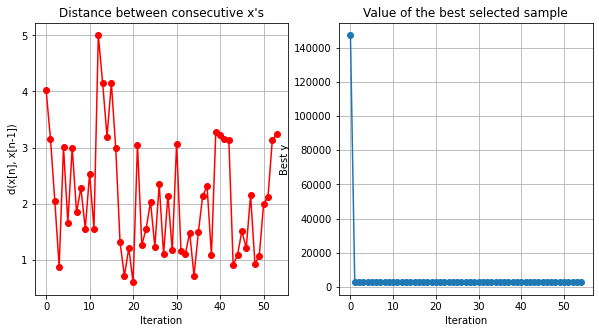

k-fold:  40%|████      | 2/5 [00:00<00:00, 16.14it/s]

RMSE: 2614.560944071408
Parâmetros: [1.0e-04 1.1e+00 4.0e+00]
BayesianLinearRegressionNew True


k-fold: 100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


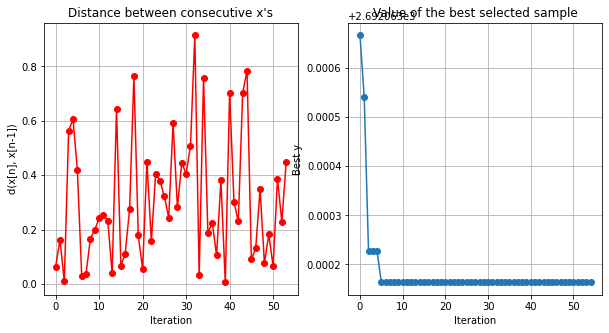

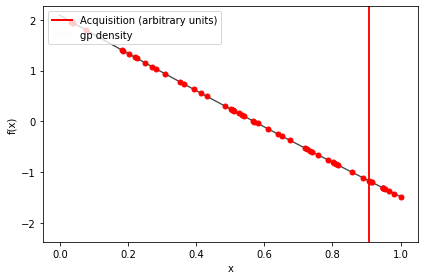

RMSE: 2692.063163386917
Parâmetros: [1.]
BayesianPolinomialLinearRegressionNew True


k-fold: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


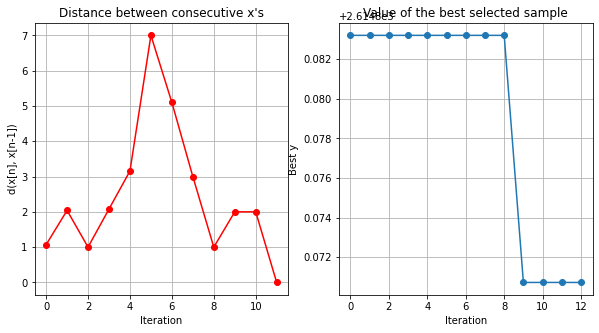

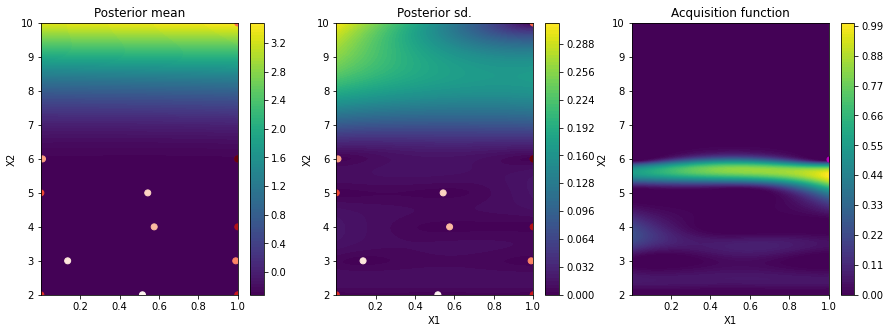

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

RMSE: 2614.8707309389138
Parâmetros: [1. 2.]
BayesianRBFLinearRegression True


k-fold: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


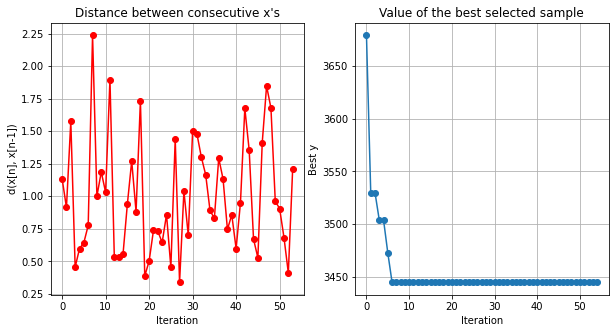

RMSE: 3444.510618966294
Parâmetros: [ 1. -1.  1.]


In [27]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold', 'tentativa'])


for modelo, (Classe, dominio) in modelos.items():
    print(modelo, treinar[modelo])
    if treinar[modelo]:
        resultado_parcial = otimizacao_bayesiana(Modelo=Classe, dominio=dominio, X=X_train, y=y_train, metrica=metrica, max_iter=bo_max_iter)
        relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
        resultado_parcial.to_csv(f'resultados/parciais/{modelo}_{metrica}.csv')

#### Resultado prelimiar

In [28]:
relatorio_condensado = \
relatorio_modelos.groupby(['modelo', 'tentativa']) \
                  .agg(['mean', 'std']) \
                  .reset_index() \
                  .sort_values(by=(metrica, 'mean')) \
                  .groupby('modelo').first()

relatorio_condensado

tentativa         rmse              \
                                                        mean         std   
modelo                                                                     
BayesianLinearRegression                   31.0  2692.039913  289.559110   
BayesianLinearRegressionNew                 5.0  2692.063163  289.574077   
BayesianPolinomialLinearRegression         10.0  2614.560944  304.838846   
BayesianPolinomialLinearRegressionNew       9.0  2614.870731  307.240134   
BayesianRBFLinearRegression                 9.0  3444.510619  209.200218   
RegressaoLinear                             2.0  2692.709122  290.647245   

                                               nlpd                
                                               mean           std  
modelo                                                             
BayesianLinearRegression               1.713982e+01  4.256972e-02  
BayesianLinearRegressionNew            1.825223e+01  2.654043e-02  
BayesianPolinomialLinearRegression     1.710616e+01  4.745977e-02  
BayesianPolinomialLinearRegressionNew  1.825267e+01  2.662505e-02  
BayesianRBFLinearRegression            1.825223e+01  2.653061e-02  
RegressaoLinear                        3.659132e+66  8.353381e+65

### Resultado Final

In [29]:
melhores_hiperparametros = {}

for modelo, tentativa in relatorio_condensado[['tentativa']].reset_index().values:
    resultado = (relatorio_modelos.modelo == modelo) & (relatorio_modelos.tentativa == tentativa)
    melhores_hiperparametros[modelo] = relatorio_modelos[resultado].parametros.values[0]

pd.DataFrame(melhores_hiperparametros)

,BayesianLinearRegression,BayesianLinearRegressionNew,BayesianPolinomialLinearRegression,BayesianPolinomialLinearRegressionNew,BayesianRBFLinearRegression,RegressaoLinear
alphaInit,0.054411,NaN,0.0001,NaN,NaN,NaN
lambdaInit,0.945529,NaN,1.1000,NaN,NaN,NaN
sig2_error,NaN,1.0,NaN,1.0,1.0,NaN
order,NaN,NaN,4.0000,2.0,NaN,NaN
mean_rbf_arbitrario,NaN,NaN,NaN,NaN,-1.0,NaN
lambda_rbf_arbitrario,NaN,NaN,NaN,NaN,1.0,NaN


In [30]:
relatorio_final = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd'])


for i, (modelo, hiperparametros) in tqdm(enumerate(melhores_hiperparametros.items())):
    Modelo, dominio = modelos[modelo]
    resultado = treinar_modelo(Modelo, X_train, X_test, y_train, y_test, **hiperparametros)
                                         
    relatorio_final.loc[i] = resultado
    

# # Calcular valor do RMSE do y na dimensão original
# relatorio['rmse_dimensao_original'] = y_scaler.inverse_transform(relatorio.rmse.values.reshape((-1, 1)))

# # Nome do arquivo
# nomes_modelos = relatorio.modelo.unique()
# nomes_modelos.sort()

# nome_arquivo = f'resultados/final/{fold_externo}_{metrica}_{"-".join(nomes_modelos)}.csv'
# relatorio.to_csv(nome_arquivo)
relatorio_final

6it [00:01,  3.58it/s]


,modelo,parametros,rmse,nlpd
0,BayesianLinearRegression,"{'alphaInit': 0.05441096663317377, 'lambdaInit...",1.170770e+04,1.714196e+01
1,BayesianLinearRegressionNew,{'sig2_error': 1.0},1.176142e+04,1.825377e+01
2,BayesianPolinomialLinearRegression,"{'alphaInit': 0.0001, 'lambdaInit': 1.1, 'orde...",1.098258e+09,1.712479e+01
3,BayesianPolinomialLinearRegressionNew,"{'sig2_error': 1.0, 'order': 2.0}",6.815179e+05,1.825912e+01
4,BayesianRBFLinearRegression,"{'sig2_error': 1.0, 'mean_rbf_arbitrario': -1....",3.391376e+03,1.825233e+01
5,RegressaoLinear,{},1.176127e+04,6.916371e+67
